# Aggregating results by using GROUP BY
<!--
  ~ Licensed to the Apache Software Foundation (ASF) under one
  ~ or more contributor license agreements.  See the NOTICE file
  ~ distributed with this work for additional information
  ~ regarding copyright ownership.  The ASF licenses this file
  ~ to you under the Apache License, Version 2.0 (the
  ~ "License"); you may not use this file except in compliance
  ~ with the License.  You may obtain a copy of the License at
  ~
  ~   http://www.apache.org/licenses/LICENSE-2.0
  ~
  ~ Unless required by applicable law or agreed to in writing,
  ~ software distributed under the License is distributed on an
  ~ "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
  ~ KIND, either express or implied.  See the License for the
  ~ specific language governing permissions and limitations
  ~ under the License.
  -->

This tutorial demonstrates how to work with [GROUP BY](https://druid.apache.org/docs/27.0.0/querying/sql#group-by) to aggregate rows and produce metrics from underlying measures at query time and during ingestion.

## Table of contents

- [Prerequisites](#Prerequisites)
- [Initalization](#Initalization)
- [Next section](#Nextsection)
- etc

## Prerequisites

This tutorial works with Druid 27.0.0 or later.

#### Run with Docker

<!-- Profiles are:
`druid-jupyter` - just Jupyter and Druid
`all-services` - includes Jupyter, Druid, and Kafka
 -->

Launch this tutorial and all prerequisites using the `druid-jupyter` profile of the Docker Compose file for Jupyter-based Druid tutorials. For more information, see [Docker for Jupyter Notebook tutorials](https://druid.apache.org/docs/latest/tutorials/tutorial-jupyter-docker.html).
   
#### Run without Docker

If you do not use the Docker Compose environment, you need the following:

* A running Apache Druid instance, with a `DRUID_HOST` local environment variable containing the server name of your Druid router
* [druidapi](https://github.com/apache/druid/blob/master/examples/quickstart/jupyter-notebooks/druidapi/README.md), a Python client for Apache Druid. Follow the instructions in the Install section of the README file.

 <!-- Remove as needed -->
* A running Apache Kafka instance, with a `KAFKA_HOST` local environment variable containing the broker server name.
* [matplotlib](https://matplotlib.org/), a library for creating visualizations in Python.
* [pandas](https://pandas.pydata.org/), a data analysis and manipulation tool.

### Initialization

Run the next cell to set up the Druid Python client's connection to Apache Druid.

If successful, the Druid version number will be shown in the output.

In [1]:
import druidapi
import os

if 'DRUID_HOST' not in os.environ.keys():
    druid_host=f"http://localhost:8888"
else:
    druid_host=f"http://{os.environ['DRUID_HOST']}:8888"
    
print(f"Opening a connection to {druid_host}.")
druid = druidapi.jupyter_client(druid_host)

display = druid.display
sql_client = druid.sql
status_client = druid.status

status_client.version

Opening a connection to http://router:8888.


'27.0.0-SNAPSHOT'

<!-- Include these cells if you're relying on someone ingesting example data through the console -->

### Load example data

Once your Druid environment is up and running, ingest the sample data for this tutorial.

Run the following cell to create a table called `example-koalas-groupby`. Notice {the use of X as a timestamp | only required columns are ingested | WHERE / expressions / GROUP BY are front-loaded | partitions on X period and clusters by Y}.

When completed, you'll see a description of the final table.

<!--

Replace `example-dataset-notebook` with a unique table name for this notebook.

- Always prefix your table name with `example-`
- If using the standard example datasets, use the following standard values for `dataset`:

    wikipedia       wikipedia
    koalas          KoalasToTheMax one day
    koalanest       KoalasToTheMax one day (nested)
    nyctaxi3        NYC Taxi cabs (3 files)
    nyctaxi         NYC Taxi cabs (all files)
    flights         FlightCarrierOnTime (1 month)

-->

Monitor the ingestion task process in the Druid console.

In [2]:
sql='''
REPLACE INTO "example-koalas-groupby" OVERWRITE ALL
WITH "ext" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"http","uris":["https://static.imply.io/example-data/kttm-v2/kttm-v2-2019-08-25.json.gz"]}',
    '{"type":"json"}'
  )
) EXTEND ("timestamp" VARCHAR, "agent_category" VARCHAR, "agent_type" VARCHAR, "browser" VARCHAR, "browser_version" VARCHAR, "city" VARCHAR, "continent" VARCHAR, "country" VARCHAR, "version" VARCHAR, "event_type" VARCHAR, "event_subtype" VARCHAR, "loaded_image" VARCHAR, "adblock_list" VARCHAR, "forwarded_for" VARCHAR, "language" VARCHAR, "number" VARCHAR, "os" VARCHAR, "path" VARCHAR, "platform" VARCHAR, "referrer" VARCHAR, "referrer_host" VARCHAR, "region" VARCHAR, "remote_address" VARCHAR, "screen" VARCHAR, "session" VARCHAR, "session_length" BIGINT, "timezone" VARCHAR, "timezone_offset" VARCHAR, "window" VARCHAR))
SELECT
  TIME_PARSE("timestamp") AS "__time",
  "agent_category",
  "agent_type",
  "browser",
  "browser_version",
  "city",
  "continent",
  "country",
  "version",
  "event_type",
  "event_subtype",
  "loaded_image",
  "adblock_list",
  "forwarded_for",
  MV_TO_ARRAY("language") AS "language",
  "number",
  "os",
  "path",
  "platform",
  "referrer",
  "referrer_host",
  "region",
  "remote_address",
  "screen",
  "session",
  "session_length",
  "timezone",
  "timezone_offset",
  "window"
FROM "ext"
PARTITIONED BY DAY
'''

sql_client.run_task(sql)
sql_client.wait_until_ready('example-koalas-groupby')
display.table('example-koalas-groupby')

Position,Name,Type
1,__time,TIMESTAMP
2,agent_category,VARCHAR
3,agent_type,VARCHAR
4,browser,VARCHAR
5,browser_version,VARCHAR
6,city,VARCHAR
7,continent,VARCHAR
8,country,VARCHAR
9,version,VARCHAR
10,event_type,VARCHAR


<!-- Include these cells if you need additional Python modules -->

Finally, run the following cell to import additional Python modules that you will use to X, Y, Z.

In [41]:
# Add your modules here, remembering to align this with the prerequisites section

import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## Understanding `GROUP BY`

You can combine rows of common values in your result set by using the `GROUP BY` clause. When the row are aggregated, you can optionally produce aggregations like sums and averages from values in the underlying measures in your `TABLE`.

While `WHERE` filters the source rows, the `HAVING` clause filters the result set by refering to those calculated aggregations.

In this section, you'll run some `GROUP BY` statements on the sample dataset that show `GROUP BY` and `HAVING` in action.

Run the following cell to generate a table of results from the example dataset.

The `GROUP BY` combines data from the raw data with common a `browser`, and generates the average, maximum, and minimum time taken to complete a level.

The `WHERE` clause uses a `TIME_IN_INTERVAL` function to ensure we only retrieve rows for a specific time period - good practice for all Druid queries. In this case, only events between 10am and 6pm on the 25th August 2019 are included.

In [96]:
sql='''
SELECT
  "loaded_image",
  avg(session_length) AS "timetakenms_average",
  max(session_length) AS "timetakenms_max",
  min(session_length) AS "timetakenms_min",
  count(session_length) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T10:00:00/2019-08-25T18:00:00')
GROUP BY 1
'''

display.sql(sql)

loaded_image,timetakenms_average,timetakenms_max,timetakenms_min,count
Custom image,459899,253805929,2,10451
http://koalastothemax.com/img/koalas.jpg,121510,7832742,11,3973
http://koalastothemax.com/img/koalas1.jpg,206308,60448705,12,4311
http://koalastothemax.com/img/koalas2.jpg,256468,38379993,15,4182
http://koalastothemax.com/img/koalas3.jpg,95155,3112980,13,4736
http://www.koalastothemax.com/img/koalas.jpg,238353,198140123,22,9535
http://www.koalastothemax.com/img/koalas1.jpg,193270,50209957,19,9704
http://www.koalastothemax.com/img/koalas2.jpg,174884,45117581,15,9834
http://www.koalastothemax.com/img/koalas3.jpg,178235,62805556,14,9725
https://koalastothemax.com/img/koalas.jpg,151239,85797915,17,22595


## Functions on dimensions in the `GROUP BY` clause

### Apply a function to the grouped dimension

A function can be applied to the raw data as part of a query. This makes it possible to carry out operations on the dimensions that are used in a `GROUP BY` operation before the results are calculated.

Run the cell below, where a regular expression has been applied to the `loaded_image` data to extract only the filename by using [`REGEXP_EXTRACT`](https://druid.apache.org/docs/latest/querying/sql-scalar#string-functions).

The results of this expression are then used in the `GROUP BY`, providing a results table that only contains the filename.

In [97]:
sql='''
SELECT
  REGEXP_EXTRACT("loaded_image",'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg)$') AS "loaded_image_filename",
  avg(session_length) AS "timetakenms_average",
  max(session_length) AS "timetakenms_max",
  min(session_length) AS "timetakenms_min",
  count(session_length) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T10:00:00/2019-08-25T18:00:00')
GROUP BY 1
ORDER BY 2 DESC
'''

display.sql(sql)

loaded_image_filename,timetakenms_average,timetakenms_max,timetakenms_min,count
koalas3.jpg,651515,739199348,13,37536
,459899,253805929,2,10451
koalas1.jpg,432661,322968643,-15325,36512
koalas2.jpg,211683,248564724,3,36976
koalas.jpg,169047,198140123,11,37963


### Applying functions to the time dimension

The SQL in the cell applies a time function, [`TIME_EXTRACT`](https://druid.apache.org/docs/27.0.0/querying/sql-functions#time_extract), to extract the `HOUR` from the underlying data.

Notice that the `WHERE` clause ensures that only events on the 25th August are used.

Run the next cell to store the results in a Pandas dataframe and produce a histogram.

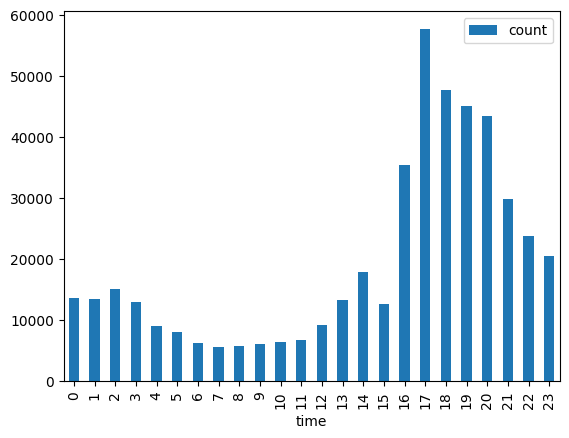

In [108]:
sql='''
SELECT
  TIME_EXTRACT("__time", 'HOUR') AS "time",
  count(*) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T00:00:00/2019-08-26T00:00:00')
GROUP BY 1
'''

df = pd.DataFrame(sql_client.sql(sql))
df.plot.bar(x='time', y='count')
plt.show()

The function can be applied in two ways - one where timezones are specified, and one without.

Run this cell to see how this function works.

In [ ]:
sql='''
SELECT
  TIME_EXTRACT("__time", 'HOUR', 'America/Los_Angeles') AS "time_LA",
  TIME_EXTRACT("__time", 'HOUR') AS "time",
  TIME_EXTRACT("__time", 'HOUR', 'Europe/Copenhagen') AS "time_Cop",
  TIME_EXTRACT("__time", 'HOUR', 'Asia/Shanghai') AS "time_Sha",
  count(*) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T00:00:00/2019-08-26T00:00:00')
GROUP BY 1,2,3,4
ORDER BY 2 ASC
'''

display.sql(sql)

time_LA,time,time_Cop,time_Sha,count
17,0,2,8,13587
18,1,3,9,13441
19,2,4,10,15005
20,3,5,11,12878
21,4,6,12,9083
22,5,7,13,8056
23,6,8,14,6147
0,7,9,15,5557
1,8,10,16,5742
2,9,11,17,6104


For timecharts, the `TIME_FLOOR` function is particularly useful.

The [`TIME_FLOOR`](https://druid.apache.org/docs/latest/querying/sql-functions#time_floor) function is used against `__time` to return only the date and hour for each timestamp in the source data. The result of this is then passed to the `STRING_FORMAT` function to apply string formatting.

The [`TIME_IN_INTERVAL`](https://druid.apache.org/docs/27.0.0/querying/sql-functions#time_in_interval) ensures the result set only contains results for events on the 25th August 2019.

Two aggregates are calculated - the number of sessions (`count`) and the sum total length of all sessions (`timetakenms`).

The results of this query are stored in a dataframe and then plotted into a timechart of the period.

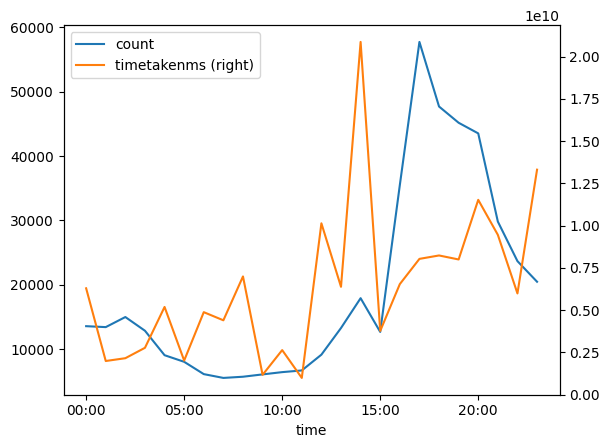

In [131]:
sql='''
SELECT
  STRING_FORMAT('%tR',TIME_FLOOR("__time", 'PT1H')) AS "time",
  count(*) AS "count",
  sum(session_length) AS "timetakenms"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T00:00:00/2019-08-26T00:00:00')
GROUP BY 1
'''

df = pd.DataFrame(sql_client.sql(sql))

fig, ax = plt.subplots()

df.plot(x = 'time', y = 'count', ax = ax) 
df.plot(x = 'time', y = 'timetakenms', ax = ax, secondary_y = True) 
plt.show()

## Filtering with `GROUP BY`

While the `WHERE` clause filters rows from the source data that are used in your query, `HAVING` filters the final result set.

In this section, see how these two mechanisms for filtering data can be used with `GROUP BY` queries.

### Filtering with `WHERE` and `GROUP BY`

You may have noticed that the results of one of the queries above included rows where no filename could be found in the source data.

To prevent this from happening, we might add a `LIKE` function in the `WHERE` clause to ensure source rows for the query contain a JPG image in the `loaded_image`.

In [111]:
sql='''
SELECT
  REGEXP_EXTRACT("loaded_image",'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg)$') AS "loaded_image_filename",
  avg(session_length) AS "timetakenms_average",
  max(session_length) AS "timetakenms_max",
  min(session_length) AS "timetakenms_min",
  count(session_length) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T10:00:00/2019-08-25T18:00:00')
AND "loaded_image" LIKE '%jpg'
GROUP BY 1
ORDER BY 2 DESC
'''

display.sql(sql)

loaded_image_filename,timetakenms_average,timetakenms_max,timetakenms_min,count
koalas3.jpg,651515,739199348,13,37536
koalas1.jpg,432661,322968643,-15325,36512
koalas2.jpg,211683,248564724,3,36976
koalas.jpg,169047,198140123,11,37963


### Filter with `HAVING` and `GROUP BY`

A `WHERE` clause only filters source data. Since the `loaded_image_filename` dimension is calculated, we cannot use `WHERE` to filter the result set. This SQL, for example, would be illegal:

```sql
WHERE "loaded_image_filename" = 'koalas2.jpg'
```

The `HAVING` clause filters the final result set, allowing filters to be created that address calculated columns directly.

In the following SQL, the calculated column, `loaded_image_filename`, is used in the `HAVING` clause to remove any empty results, an alternative approach to the `WHERE` filter above.

Running this cell will show that the results match. Remember, however, that the `WHERE`-based query is far more efficient than this new query as it draws fewer rows out of the source `TABLE`. In this alternative form, filtering happens very late in query execution.

In [115]:
sql='''
SELECT
  REGEXP_EXTRACT("loaded_image",'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg)$') AS "loaded_image_filename",
  avg(session_length) AS "timetakenms_average",
  max(session_length) AS "timetakenms_max",
  min(session_length) AS "timetakenms_min",
  count(session_length) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T10:00:00/2019-08-25T18:00:00')
GROUP BY 1
HAVING "loaded_image_filename" IS NOT NULL
ORDER BY 2 DESC
'''

display.sql(sql)

loaded_image_filename,timetakenms_average,timetakenms_max,timetakenms_min,count
koalas3.jpg,651515,739199348,13,37536
koalas1.jpg,432661,322968643,-15325,36512
koalas2.jpg,211683,248564724,3,36976
koalas.jpg,169047,198140123,11,37963


A more common use of `HAVING` is to filter results based on the output of aggregate functions.

Run the following cell to see the list of images where, after the average session length was calculated, it was found that a particular image took over 300000 milliseconds (300 seconds) to complete on average.

In [117]:
sql='''
SELECT
  REGEXP_EXTRACT("loaded_image",'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg)$') AS "loaded_image_filename",
  avg(session_length) AS "timetakenms_average",
  max(session_length) AS "timetakenms_max",
  min(session_length) AS "timetakenms_min",
  count(session_length) AS "count"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T10:00:00/2019-08-25T18:00:00')
AND "loaded_image" LIKE '%jpg'
GROUP BY 1
HAVING "timetakenms_average" > 300000
ORDER BY 2 DESC
'''

display.sql(sql)

loaded_image_filename,timetakenms_average,timetakenms_max,timetakenms_min,count
koalas3.jpg,651515,739199348,13,37536
koalas1.jpg,432661,322968643,-15325,36512


## Types of `GROUP BY` execution plan

There are several execution engines might being used for `GROUP BY` operations. `EXPLAIN PLAN` shows specifically which will be used for each type of query.

In this section, see `EXPLAIN PLAN` results for some `GROUP BY` queries.

### The `timeseries` engine

The following cell contains a `GROUP BY` query that matches the [requirements](https://druid.apache.org/docs/latest/querying/sql-translation#query-types) for the [`timeseries`](https://druid.apache.org/docs/27.0.0/querying/timeseriesquery) execution.

Run the following cell to see the `EXPLAIN PLAN` for the query, noting that the `queryType` is `timeseries`.

In [132]:
sql='''
SELECT
  TIME_FLOOR("__time", 'PT1H') AS "time",
  count(*) AS "count",
  sum(session_length) AS "timetakenms"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T00:00:00/2019-08-26T00:00:00')
GROUP BY 1
'''

print(json.dumps(json.loads(sql_client.explain_sql(sql)['PLAN']), indent=2))

[
  {
    "query": {
      "queryType": "timeseries",
      "dataSource": {
        "type": "table",
        "name": "example-koalas-groupby"
      },
      "intervals": {
        "type": "intervals",
        "intervals": [
          "2019-08-25T00:00:00.000Z/2019-08-26T00:00:00.000Z"
        ]
      },
      "granularity": "HOUR",
      "aggregations": [
        {
          "type": "count",
          "name": "a0"
        },
        {
          "type": "longSum",
          "name": "a1",
          "fieldName": "session_length"
        }
      ],
      "context": {
        "queryId": "b35544fc-1840-4fec-954c-cdcec4e77da5",
        "skipEmptyBuckets": true,
        "sqlQueryId": "b35544fc-1840-4fec-954c-cdcec4e77da5",
        "timestampResultField": "d0"
      }
    },
    "signature": [
      {
        "name": "d0",
        "type": "LONG"
      },
      {
        "name": "a0",
        "type": "LONG"
      },
      {
        "name": "a1",
        "type": "LONG"
      }
    ],
    "columnM

### The `groupby` engine

Review then run the SQL in the cell below.

This `GROUP BY` query additionally groups rows by the operating system (`os`), leading Druid to use the `groupby` query type.

Run the cell to retrieve an `EXPLAIN PLAN` for the query above. Notice that the `queryType` is `groupBy`. This indicates that Druid is using the [`groupby`](https://druid.apache.org/docs/latest/querying/groupbyquery) execution engine.

In [133]:
sql='''
SELECT
  TIME_FLOOR("__time", 'PT1H') AS "__time_by_hour",
  "os",
  count(*) AS "count",
  sum(session_length) AS "timetakenms"
FROM "example-koalas-groupby"
WHERE TIME_IN_INTERVAL("__time", '2019-08-25T04:00:00/2019-08-25T06:00:00')
GROUP BY 1,2
'''

print(json.dumps(json.loads(sql_client.explain_sql(sql)['PLAN']), indent=2))

[
  {
    "query": {
      "queryType": "groupBy",
      "dataSource": {
        "type": "table",
        "name": "example-koalas-groupby"
      },
      "intervals": {
        "type": "intervals",
        "intervals": [
          "2019-08-25T04:00:00.000Z/2019-08-25T06:00:00.000Z"
        ]
      },
      "virtualColumns": [
        {
          "type": "expression",
          "name": "v0",
          "expression": "timestamp_floor(\"__time\",'PT1H',null,'UTC')",
          "outputType": "LONG"
        }
      ],
      "granularity": {
        "type": "all"
      },
      "dimensions": [
        {
          "type": "default",
          "dimension": "v0",
          "outputName": "d0",
          "outputType": "LONG"
        },
        {
          "type": "default",
          "dimension": "os",
          "outputName": "d1",
          "outputType": "STRING"
        }
      ],
      "aggregations": [
        {
          "type": "count",
          "name": "a0"
        },
        {
          "t

### The `topN` engine

The `TopN` execution pattern applies approximation to `GROUP BY` results.

Try the [TopN](02-approx-ranking.ipynb) notebook on using approximation with `GROUP BY` queries.

## Cleanup

Run the following cell to drop the table.

In [ ]:
druid.datasources.drop("example-koalas-groupby")

## Summary

* You learned this
* Remember this

## Go further

* Try this out on your own data
* Solve for problem X that is't covered here

## Learn more

* Review the available [aggregation functions](https://druid.apache.org/docs/latest/querying/sql-aggregations)
* Read more about the [groupby](https://druid.apache.org/docs/latest/querying/groupbyquery) execution engine.
* Find out [when each type of query mode is used](https://druid.apache.org/docs/latest/querying/sql-translation#query-types) from the documentation.
* Take a [look at](https://www.novixys.com/blog/java-string-format-examples/#31_Date_and_Time_Formatting) other `STRING_FORMAT` options
* Try the [TopN](02-approx-ranking.ipynb) notebook on using approximation with `GROUP BY` queries.
* Review the list `timezones`[https://www.joda.org/joda-time/timezones.html].

In [ ]:
# STANDARD CODE BLOCKS

# When just wanting to display some SQL results
display.sql(sql)

# When ingesting data:
sql_client.run_task(sql)
sql_client.wait_until_ready('wikipedia-en')
display.table('wikipedia-en')

# When you want to make an EXPLAIN look pretty
print(json.dumps(json.loads(sql_client.explain_sql(sql)['PLAN']), indent=2))

# When you want a simple plot
df = pd.DataFrame(sql_client.sql(sql))
df.plot(x='Tail_Number', y='Flights', marker='o')
plt.xticks(rotation=45, ha='right')
plt.gca().get_legend().remove()
plt.show()

# When you want to add some query context parameters
req = sql_client.sql_request(sql)
req.add_context("useApproximateTopN", "false")
resp = sql_client.sql_query(req)

# When you want to compare two different sets of results
df3 = df1.compare(df2, keep_equal=True)
df3